<img src="http://xarray.pydata.org/en/stable/_static/logos/Xarray_Logo_RGB_Final.png" width="500px"></img>

# 🌧 Forecasting with Xarray and the HRRR 🌨

---

## Overview

The examples in this tutorial focus on the fundamentals of working with gridded, labeled data using Xarray. Xarray works by introducing additional abstractions into otherwise ordinary data arrays. In this tutorial, we demonstrate the usefulness of these abstractions. The examples in this tutorial explain how the proper usage of Xarray abstractions generally leads to simpler, more robust code.

The following topics will be covered in this tutorial:

1. Access HRRR Data Stored on the Cloud
2. Use MetPy to clean the data
3. Forecast for Baltimore!

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [NumPy Basics](../numpy/numpy-basics) | Necessary |  |
| [Introduction to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html)| Neccessary | Familiarity with xarray data structures |
| [Introduction to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html)| Neccessary | Familiarity with xarray data structures |
| [Datetime](https://foundations.projectpythia.org/core/datetime/datetime.html) | Helpful | Familiarity with time formats and the `datetime` object |



- **Time to learn**: 40 minutes

---

## Imports

In earlier tutorials, we explained the abbreviation of commonly used scientific Python package names in import statements. Just as `numpy` is abbreviated `np`, and just as `pandas` is abbreviated `pd`, the name `xarray` is often abbreviated `xr` in import statements.

In [1]:
from datetime import datetime, timedelta, UTC

# Core libraries in the scientific python/pangeo space
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import metpy

# For Data Access
from siphon.catalog import TDSCatalog

## Access HRRR Data Stored in the Cloud
Our first step is finding data to use for our forecast! For today's exercise, let's use the HRRR model data, which is stored on Amazon Web Services (AWS).

### The HRRR Model
The first step is finding a dataset to use. In today's tutorial, we will use data from the High Resolution Rapid Refresh (HRRR), a weather forecasting model developed and produced by the National Oceanic and Atmospheric Administration.

### The Zarr Archive
For a number of years, the Mesowest group at the University of Utah has hosted an archive of data from NCEP’s High Resolution Rapid Refresh model. This data, originally in GRIB-2 format, has been converted into Zarr and is freely available “in the cloud”, on Amazon Web Service’s Simple Storage Service, otherwise known as S3. Data is stored in S3 in a manner akin to (but different from) a Linux filesystem, using a bucket and object model.

To interactively browse the contents of this archive, go to this link: HRRRZarr File Browser on AWS

To access Zarr-formatted data stored in an S3 bucket, we follow a 3-step process:

- Create URL(s) pointing to the bucket and object(s) that contain the data we want

- Pass the map(s) to Xarray’s open_dataset or open_mfdataset methods, and specify zarr as the format, via the engine argument, as well as that we are accessing anonymously (without credentials)

### Configure the URLs
We start by setting up our url to search for the data. We can use the current time (in Coordinated Universal Time, or UTC). Since the HRRR model only runs for longer durations at 6 hour invervals, we would like to access the most recent 0, 6, 12, or 18 UTC run.

#### Determining the Time

Let's start with the time!

In [2]:
datetime = datetime.now(UTC)
date = datetime.strftime("%Y%m%d")
date

'20240119'

Now, the hour. This where we need to add some logic. By default, we get the current hour.

In [3]:
int(datetime.strftime("%H"))

17

If we divide by 6, including the remainder, we can reveal the most recent 0, 6, 12, or 18 UTC run.

In [4]:
(int(datetime.strftime("%H")) // 6)

2

We still need to convert that back to an interval of 6 - so we can multiply by 6!

In [5]:
hour = ((int(datetime.strftime("%H")) - 2) // 6) * 6
hour

12

#### Choose a variable and vertical level
Now, we need to choose a variable. One of the most important variables for the weather forecast challenge is temperature! Both the high and low temperature. So let's start there. For the HRRR, the variable is titled `TMP`, with a height of `2m_above_ground`.

In [6]:
var = 'TMP'
level = '2m_above_ground'

#### Build the URLs
Now that we have all of our variables, we can build the URLs! We need two urls, as we will access the variable metadata as well as the dataset itself.

In [7]:
# Format the bins
url1 = f's3://hrrrzarr/sfc/{date}/{date}_{hour:02d}z_fcst.zarr/{level}/{var}/{level}'
url2 = f's3://hrrrzarr/sfc/{date}/{date}_{hour:02d}z_fcst.zarr/{level}/{var}/'

print(url1, url2)

s3://hrrrzarr/sfc/20240119/20240119_12z_fcst.zarr/2m_above_ground/TMP/2m_above_ground s3://hrrrzarr/sfc/20240119/20240119_12z_fcst.zarr/2m_above_ground/TMP/


### Read the Dataset using Xarray
Now that we have our URLs, we can pass these to `open_mfdataset`, which is short for "Open Multifile Dataset". We specify that we are reading zarr files, and that we are accessing anonymously (without Amazon Web Service credentials).

In [8]:
ds = xr.open_mfdataset([url1,url2],
                       engine='zarr',
                       storage_options={'anon':True})
ds

<xarray.Dataset>
Dimensions:                  (time: 48, projection_y_coordinate: 1059,
                              projection_x_coordinate: 1799)
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2024-01-19T13:00:00 ... 20...
Data variables:
    TMP                      (time, projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(48, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] ...

In [9]:
temp = ds.TMP
temp

<xarray.DataArray 'TMP' (time: 48, projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)>
dask.array<open_dataset-TMP, shape=(48, 1059, 1799), dtype=float16, chunksize=(48, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2024-01-19T13:00:00 ... 20...
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP
    units:       K

## Cleaning the Data
As an atmospheric scientist/meteorologist/data scientist, cleaning the data is often the most important, and tedious step to the analysis pipeline! Fortunately, our data is pretty clean already! Looking at our dataset, we have:
- Projected Coordinates
- Time
- Units

We do not have the actual latitude and longitude though... which makes subsetting for just the Baltimore area challenging.


### Access the Grid Information
Fortunately, the grid information is available in the same bucket! We populated a dictionary for you to make things easier (open the hidden cell to see how you can access this programtically).

In [10]:
grid_params = {'a': 6371229,
               'b': 6371229,
               'proj': 'lcc',
               'lon_0': 262.5,
               'lat_0': 38.5,
               'lat_1': 38.5,
               'lat_2': 38.5}

In [12]:
import s3fs
import json

fs = s3fs.S3FileSystem(anon=True)
with fs.open('s3://hrrrzarr/grid/projparams.json', 'rb') as f:
    grid_params = json.load(f)

#### Build the Projection
Once we have the grid information, we can build the projection! We pass the parameters to Cartopy, a mapping library, which returns a nice map detailing our projected coordinate system. Notice how it is centered on North America!

In [13]:
projData= ccrs.LambertConformal(central_longitude=grid_params["lon_0"],
                                central_latitude=grid_params["lat_0"],
                                standard_parallels=[grid_params["lat_1"],
                                                    grid_params["lat_1"]],
                                globe=ccrs.Globe(semimajor_axis=grid_params["a"],
                                                 semiminor_axis=grid_params["b"]))
projData

<Projected CRS: +proj=lcc +ellps=WGS84 +a=6371229 +b=6371229 +lon_ ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: unknown
- Ellipsoid: unknown
- Prime Meridian: Greenwich

#### Add this to our data
Once we have this projection, we can use MetPy to add this to the dataset, making indexing and visualization much easier.

Notice how we now have `metpy_crs` as a coordinate in the dataset.

In [14]:
temp = temp.metpy.assign_crs(projData.to_cf())
temp

<xarray.DataArray 'TMP' (time: 48, projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)>
dask.array<open_dataset-TMP, shape=(48, 1059, 1799), dtype=float16, chunksize=(48, 150, 150), chunktype=numpy.ndarray>
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2024-01-19T13:00:00 ... 20...
    metpy_crs                object Projection: lambert_conformal_conic
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP
    units:       K

### Convert our Units to Fahrenheit

The Weather Challenge requires temperature to be in degrees Fahrenheit. Fortunately, MetPy has units-support built in, so we can easily complete this conversion without looking up with conversion factors!

In [15]:
temp = temp.metpy.convert_units('degF')
temp

<xarray.DataArray 'TMP' (time: 48, projection_y_coordinate: 1059,
                         projection_x_coordinate: 1799)>
<Quantity(dask.array<truediv, shape=(48, 1059, 1799), dtype=float16, chunksize=(48, 150, 150), chunktype=numpy.ndarray>, 'degree_Fahrenheit')>
Coordinates:
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
  * time                     (time) datetime64[ns] 2024-01-19T13:00:00 ... 20...
    metpy_crs                object Projection: lambert_conformal_conic
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP

## Forecast for Baltimore!
Now that we have our cleaned dataset, we can get to the analysis! Let's start with subsetting the data near Baltimore.

### Subset the nearest point to Baltimore, Maryland

Baltimore as the coordinates:
- -76.6122 degrees West
- 39.2904 degrees North

Let's pass this to MetPy's transformation function to determine our indices to slice from the dataset. This converts from a non-projected coordinate system (lat, lon) to a projected coordinate system (lambert conformal).

In [22]:
latitude = 39.2904
longitude = -76.6122
my_x, my_y = temp.metpy.cartopy_crs.transform_point(longitude,
                                                    latitude,
                                                    ccrs.PlateCarree())

my_x, my_y

(1782424.7816160866, 291022.7351052607)

Now, we pass this to xarray's selection function, specifying that we would like the nearest gridpoint to this location.

In [23]:
baltimore_temperature = temp.sel(projection_x_coordinate = my_x,
                                 projection_y_coordinate = my_y,
                                 method='nearest')
baltimore_temperature

<xarray.DataArray 'TMP' (time: 48)>
<Quantity(dask.array<getitem, shape=(48,), dtype=float16, chunksize=(48,), chunktype=numpy.ndarray>, 'degree_Fahrenheit')>
Coordinates:
    projection_x_coordinate  float64 1.781e+06
    projection_y_coordinate  float64 2.907e+05
  * time                     (time) datetime64[ns] 2024-01-19T13:00:00 ... 20...
    metpy_crs                object Projection: lambert_conformal_conic
Attributes:
    GRIB_PARAM:  [2, 0, 0, 0]
    long_name:   2m_above_ground/TMP

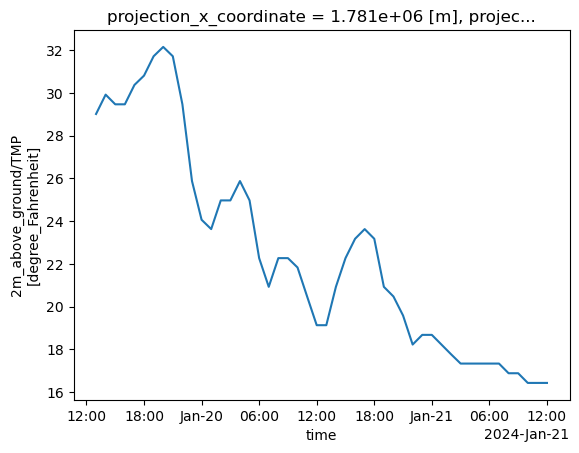

In [24]:
baltimore_temperature.plot();

### Challenge Problem
Forecast for wind speeds! This will require configuring new URLs for the data, as well as using the proper units.

Hints:
- The height of the measurement is `10m_above_ground`
- The variables are `UGRD` (u-componet of the wind) and `VGRD`(v-component of the wind)
- You will need to convert to use units of `kt` for the wind
- Wind speed can be derived from the u/v components of the wind using [`metpy.calc.wind_speed`](https://unidata.github.io/MetPy/latest/examples/calculations/Wind_Speed.html#wind-speed) 

#### Read the Data

In [25]:
level = '10m_above_ground'
var1 = 'UGRD'
var2 = 'VGRD'

# Format the bins
url1 = f's3://hrrrzarr/sfc/{date}/{date}_{hour:02d}z_fcst.zarr/{level}/{var1}/{level}'
url2 = f's3://hrrrzarr/sfc/{date}/{date}_{hour:02d}z_fcst.zarr/{level}/{var1}/'
url3 = f's3://hrrrzarr/sfc/{date}/{date}_{hour:02d}z_fcst.zarr/{level}/{var2}/{level}'
url4 = f's3://hrrrzarr/sfc/{date}/{date}_{hour:02d}z_fcst.zarr/{level}/{var2}/'


ds1 = xr.open_mfdataset([url1,
                        url2],
                        engine='zarr',
                        storage_options={'anon':True})

ds2 = xr.open_mfdataset([url3,
                         url4],
                        engine='zarr',
                        storage_options={'anon':True})
ds = xr.merge([ds1, ds2]).metpy.parse_cf()
ds

<xarray.Dataset>
Dimensions:                  (time: 48, projection_x_coordinate: 1799,
                              projection_y_coordinate: 1059)
Coordinates:
  * time                     (time) datetime64[ns] 2024-01-19T13:00:00 ... 20...
  * projection_x_coordinate  (projection_x_coordinate) float64 -2.698e+06 ......
  * projection_y_coordinate  (projection_y_coordinate) float64 -1.587e+06 ......
Data variables:
    UGRD                     (time, projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(48, 150, 150), meta=np.ndarray>
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(48,), meta=np.ndarray>
    forecast_reference_time  datetime64[ns] 2024-01-19T12:00:00
    VGRD                     (time, projection_y_coordinate, projection_x_coordinate) float16 dask.array<chunksize=(48, 150, 150), meta=np.ndarray>

#### Pre-Process with MetPy

In [26]:
# Convert to wind speed
ds["wind_speed"] = metpy.calc.wind_speed(ds.UGRD, ds.VGRD)
ds["wind_speed"].attrs["units"] = ds.UGRD.attrs["units"]

# Conver to knots
ds["wind_speed"] = ds.wind_speed.metpy.convert_units("kt")
ds["wind_speed"].attrs["units"] = "kt"

# Add the coordinate reference system
ds = ds.metpy.assign_crs(projData.to_cf())

#### Subset for Baltimore + Analyze!

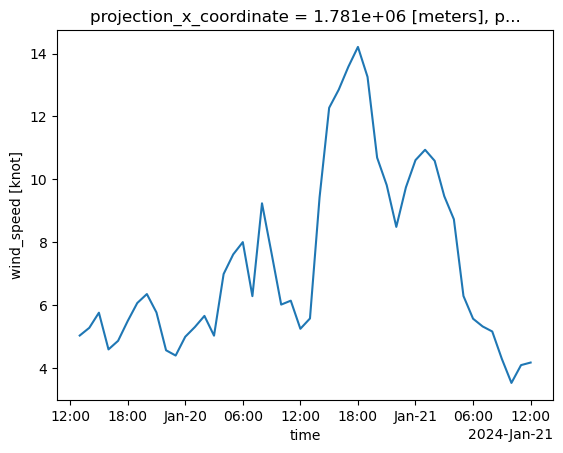

In [27]:
baltimore_wind = ds.wind_speed.sel(projection_x_coordinate = my_x,
                                   projection_y_coordinate = my_y,
                                   method='nearest')
baltimore_wind.plot();

---

## Summary

The HRRR dataset can be a useful tool for short-term forecasts, especially since an easily accessible version is stored on the public cloud. With xarray and MetPy, we can easily access and clean the data, producing analysis without needing to download the data locally. By making use of labeled coordinates and the open-source pythons stack here, our code is often easier to write, easier to read, and more robust.

### What's next?

Check out more sources on Project Pythia focused on xarray! Including:
- [Calculating ENSO with Xarray](https://foundations.projectpythia.org/core/xarray/enso-xarray.html)
- [The CMIP6 Cookbook (climate model data)](https://projectpythia.org/cmip6-cookbook/README.html)

## Resources and references

Most basic questions and issues with Xarray can be resolved with help from the material in the [Xarray documentation](http://xarray.pydata.org/en/stable/). Some of the most popular sections of this documentation are listed below:
- [Why Xarray](http://xarray.pydata.org/en/stable/getting-started-guide/why-xarray.html)
- [Quick overview](http://xarray.pydata.org/en/stable/getting-started-guide/quick-overview.html#)
- [Example gallery](http://xarray.pydata.org/en/stable/gallery.html)

Another resource you may find useful is this [Xarray Tutorial collection](https://xarray-contrib.github.io/xarray-tutorial/), created from content hosted on GitHub.